# Tutorial 104: Time Series with Pandas / NumPy

Contributed by: Avi Thaker https://github.com/athaker/CNTK
November 20, 2016

This tutorial will introduce the use of the Cognitive Toolkit for time series data. This tutorial shows how to prepare time series data for deep learning algorithims in CNTK. This tutorial will cover training a neural network, and evaluating the neural network model. We will look at the predictive potential on classification of an Exchange-traded Funds ([ETF](https://en.wikipedia.org/wiki/Exchange-traded_fund)), and in this simplified setting how one could trade it. This tutorial serves only as an example of how to use neural networks for time series analysis.
    
It is important to note that the stock market is extremely noisy and it is difficult to predict. It is more important to make sure the model is correct before setting up a trading system (there are many factors to consider including but not limited to: curve fitting bias, forward looking bias, profitability etc). 

This tutorial introduces how to use pandas_datareader package and pandas. Please note, this tutorial will utilize the numpy interface to CNTK which interfaces well with pandas dataframes (a structure that is well suited towards timeseries analysis - http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html). 

In [1]:
import numpy as np
import cntk
import cntk.ops as C

from cntk.blocks import default_options, Input   # Building blocks
from cntk.initializer import glorot_uniform
from cntk.layers import Dense                    # Layers
from cntk.learner import sgd, learning_rate_schedule, UnitType
from cntk.utils import get_train_eval_criterion, get_train_loss, ProgressPrinter, get_train_loss

import datetime
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# If you want to set the program to use a CUDA enabled GPU
#from cntk.device import set_default_device, gpu
#set_default_device(gpu(0))

## Importing Stock Data
We first retrieve stock data using the method `get_stock_data`. This method downloads stock data on a daily timescale from Yahoo finance (can be modified to get data from Google Finance and many other sources). http://pandas-datareader.readthedocs.io/en/latest/remote_data.html shows the many use cases for this data reader

In [2]:
# A method which obtains stock data from Yahoo finance
# Requires that you have an internet connection to retreive stock data from Yahoo finance
try:
    from pandas_datareader import data
except:
    !pip install pandas_datareader
    from pandas_datareader import data

def get_stock_data(contract, s_year, s_month, s_day, e_year, e_month, e_day):
    """
    Args:
        contract (str): the name of the stock/etf
        s_year (int): start year for data
        s_month (int): start month
        s_day (int): start day
        e_year (int): end year
        e_month (int): end month
        e_day (int): end day
    Returns:
        Pandas Dataframe: Daily OHLCV bars
    """
    start = datetime.datetime(s_year, s_month, s_day)
    end = datetime.datetime(e_year, e_month, e_day)
    bars = data.get_data_yahoo(contract, start, end)
    return bars

In [3]:
# Please check if there is trade data for the chosen stock symbol during this period
data = get_stock_data("SPY", 2000, 1,2,2017,1,1)

## Building the training paramaters
Let us assume that there may be some autocorrlative behavior of the stock market. For practical purposes we can identify this "market" as the [ETF](http://www.investopedia.com/terms/e/etf.asp) `SPY`. This is the ETF that encompases the top ~500 companies in America. We will trade under the assumption that there are some short term autocorrelation that have predictive power in the market. 

### Predicting
* Whether or not the next data for the given stock/ETF will be above or below the current day.

### Predictors
* The previous 5 days, classified if greater than the current day,

* The volume change as a percentage,

* The percentage change from the previous day.

Note, we are not feeding the neural network the price itself. Financial timeseries data are noisy. It is important to take care to not overfit the data. There is a lot we can do here (smoothing, adding more features, etc.), but will keep this tutorial simple, and demonstrate CNTK's ability to interface with timeseries data. 

In [4]:
data["diff"] = np.abs((data["Close"] - data["Close"].shift(1)) / data["Close"].fillna(0)) # The price series difference
data["v_diff"] = np.abs((data["Volume"] - data["Volume"].shift(1)) / data["Volume"].fillna(0)) # The volume difference
data["p_1"] = np.where(data["Close"] > data["Close"].shift(1), 1, 0) # 1 day back
data["p_2"] = np.where(data["Close"] > data["Close"].shift(2), 1, 0) # 2 days back
data["p_3"] = np.where(data["Close"] > data["Close"].shift(3), 1, 0) # 3 days back
data["p_4"] = np.where(data["Close"] > data["Close"].shift(4), 1, 0) # 4 days back
data["p_5"] = np.where(data["Close"] > data["Close"].shift(5), 1, 0) # 5 days back

# If you want to save the file to your local drive
#data.to_csv("PATH_TO_SAVE.csv")
data.head(10)

,Open,High,Low,Close,Volume,Adj Close,diff,v_diff,p_1,p_2,p_3,p_4,p_5
Date,,,,,,,,,,,,,
2000-01-03,148.250000,148.250000,143.875000,145.437500,8164300,106.449075,NaN,NaN,0,0,0,0,0
2000-01-04,143.531204,144.062500,139.640594,139.750000,8089800,102.286262,0.040698,0.009209,0,0,0,0,0
2000-01-05,139.937500,141.531204,137.250000,140.000000,12177900,102.469243,0.001786,0.335698,1,0,0,0,0
2000-01-06,139.625000,141.500000,137.750000,137.750000,6227200,100.822416,0.016334,0.955598,0,0,0,0,0
2000-01-07,140.312500,145.750000,140.062500,145.750000,8066500,106.677801,0.054889,0.228017,1,1,1,1,0
2000-01-10,146.250000,146.906204,145.031204,146.250000,5741700,107.043763,0.003419,0.404898,1,1,1,1,1
2000-01-11,145.812500,146.093704,143.500000,144.500000,7503700,105.762897,0.012111,0.234817,0,0,1,1,1
2000-01-12,144.593704,144.593704,142.875000,143.062500,6907700,104.710757,0.010048,0.086281,0,0,0,1,1
2000-01-13,144.468704,145.750000,143.281204,145.000000,5158300,106.128859,0.013362,0.339143,1,1,0,0,1


### What we are trying to predict
Here we are trying to predict whether or not the next day will be *above* or *below* the current day. We will represent an up day tomorrow as a 1, else a 0 if the next day is the same or below. (Note: the market is likely never going to close at the same price as it did the previous day). 

In [5]:
data["next_day"] = np.where(data["Close"].shift(-1) > data["Close"], 1, 0)
data["next_day_opposite"] = np.where(data["next_day"]==1,0,1) # The label must be one-hot encoded

# Establish the start and end date of our training timeseries (picked 2000 days before the market crash)
training_data = data["2000-01-15":"2008-01-01"]

# Including our out of sample data, this can modify to data["2008-01-02":] to include date up to now
test_data = data["2008-01-02":"2016-11-25"] 
training_features = np.asarray(training_data[["p_1","p_2","p_3","p_4","p_5","diff","v_diff"]], dtype = "float32")
training_labels = np.asarray(training_data[["next_day","next_day_opposite"]], dtype="float32")

Here we are actually building the neural network itself. We will use a simple feedforward neural network with 7 inputs, and 50 dimensions.
Try experimenting here with different sizes and number of hidden layers. What happens when we make this network large? Do we overfit the data? 

In [6]:
print(training_features.shape)

(2000, 7)


In [7]:
# Lets build the network
input_dim = 7
num_output_classes = 2 #Remember we need to have 2 since we are trying to classify if the market goes up or down 1 hot encoded
num_hidden_layers = 2
hidden_layers_dim = 50
#input = C.input_variable((inputs), np.float32)
input = Input(input_dim)
#label = C.input_variable((num_output_classes), np.float32)
label = Input(num_output_classes)

def create_model(input, num_output_classes):
    h = input
    for i in range(0,num_hidden_layers):
        h = Dense(hidden_layers_dim, 
                  init = glorot_uniform(), 
                  activation = C.relu)(h)
        
    return (Dense(num_output_classes, init=glorot_uniform(), activation=None)(h))
    

def linear_layer(input_var, output_dim):
    input_dim = input_var.shape[0]
    times_param = C.parameter(shape=(input_dim, output_dim), init=glorot_uniform())
    bias_param = C.parameter(shape=(output_dim))
    t = C.times(input_var, times_param)
    return bias_param + t

def dense_layer(input, output_dim, nonlinearity):
    r = linear_layer(input, output_dim)
    r = nonlinearity(r)
    return r;

def fully_connected_classifier_net(input, num_output_classes, hidden_layer_dim, num_hidden_layers, nonlinearity):
    h = dense_layer(input, hidden_layer_dim, nonlinearity)
    for i in range(1, num_hidden_layers):
        h = dense_layer(h, hidden_layer_dim, nonlinearity)
    r = linear_layer(h, num_output_classes)
    return r

# z = fully_connected_classifier_net(input, num_output_classes, 
#                                   hidden_layers_dim, num_hidden_layers, C.relu)

z = create_model(input, num_output_classes)
loss = C.cross_entropy_with_softmax(z, label)
label_error = C.classification_error(z, label)
lr_per_minibatch = learning_rate_schedule(0.125,UnitType.minibatch)
trainer = cntk.Trainer(z, loss, label_error, [sgd(z.parameters, lr=lr_per_minibatch)])

In [8]:
#Initialize the parameters for the trainer, we will train in large minibatches in sequential order
minibatch_size = 500
num_minibatches = int(len(training_data.index) / minibatch_size)

#Run the trainer on and perform model training
training_progress_output_freq = 1

# Visualize the loss over minibatch
plotdata = {"batchsize":[], "loss":[], "error":[]}

## Number of passes through the data, how we train timeseries data
This tutorial will differ from other tutorials, here we will not randomly send data to the the trainer, instead each minibatch will be fed sequentially  in the order of the time dimension. This key to time series data handling where  we want to "weight" the data at the end of our sample a slightly higher. You can put in multiple passes, however you will notice significant performance degredation. Try it out! Additonally, multiple passes tend to overfit the financial timeseries data.

In [9]:
tf = np.split(training_features,num_minibatches)
print(len(tf))
print(tf[0].shape)
tl = np.split(training_labels, num_minibatches)

num_passes = 1 # This is labeled specfically to show that we are only doing one pass through the data linearly in time

# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"
    if mb%frequency == 0:
        training_loss = get_train_loss(trainer)
        eval_error = get_train_eval_criterion(trainer)
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
    return mb, training_loss, eval_error

4
(500, 7)


In [10]:
# Train our neural network
tf = np.split(training_features,num_minibatches)
tl = np.split(training_labels, num_minibatches)

for i in range(num_minibatches*num_passes): # multiply by the 
    features = np.ascontiguousarray(tf[i%num_minibatches])
    labels = np.ascontiguousarray(tl[i%num_minibatches])
    
    # Specify the mapping of input variables in the model to actual minibatch data to be trained with
    trainer.train_minibatch({input : features, label : labels})
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 0.6974, Error: 53.00%
Minibatch: 1, Loss: 0.6944, Error: 55.20%
Minibatch: 2, Loss: 0.6928, Error: 45.80%
Minibatch: 3, Loss: 0.6933, Error: 47.40%


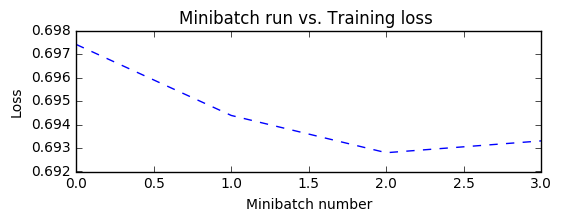

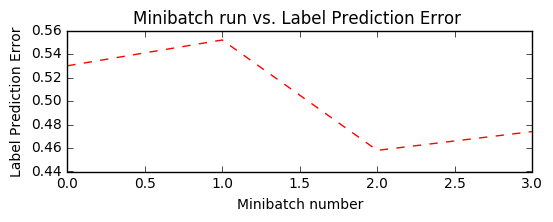

In [11]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["loss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss ')
plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["error"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error ')
plt.show()

Notice how the trend for the label predction error is still close to 50%. Remember that this is time variant, therefore it is expected that the system will have some noise as it trains through time. It should be noted, the model is still learning the market. Additionally, this is financial timeseries data so we are making progress if we have an error rate below 50%. Moreover, we are trying to classify every single data point in the stock market, this is difficult, it might be interesting to trade only when we know more.

In [12]:
# Now that we have trained the net, and we will do out of sample test to see how we did, and then more importantly, analyze
# how that set did

test_features = np.ascontiguousarray(test_data[["p_1","p_2","p_3","p_4","p_5","diff","v_diff"]], dtype = "float32")
test_labels = np.ascontiguousarray(test_data[["next_day","next_day_opposite"]], dtype="float32")

avg_error = trainer.test_minibatch({input : test_features, label : test_labels})
print(avg_error)

0.4707980383415069


Here we see that we have an error rate near 50%. At first glance this may appear to not have learned the network, but lets examine further and see if we have some predictive power.

In [13]:
out = C.softmax(z)
predicted_label_prob = out.eval({input:test_features})
test_data["p_up"] = pd.Series(predicted_label_prob[0][:,0], index = test_data.index)
test_data["p_down"] = predicted_label_prob[0][:,1]
test_data['long_entries'] = np.where((test_data.p_up > 0.55) , 1, 0)
test_data['short_entries'] = np.where((test_data.p_down > 0.55) , -1, 0)
test_data['positions'] = test_data['long_entries'].fillna(0) + test_data['short_entries'].fillna(0)

## Evaluating our Data
Here we take the output of our test set and compute the probabilities from the softmax function. Since we have probabilities we want to trade when there is a "higher" chance that we will be right, instead of just a >50% chance that the market will go in one direction. The goal is to find a signal, instead of trying to classify the market. Since the market is so noisy we want to only trade when we have an "edge" on the market. Moreover, trading frequenty has higher fees (you have to pay each time you trade).

We will say that if the prediction probability is greater than 55% in either direction we will take a position in the market. If if it >55% that the market will be up the next day we will take a 1 day long. If it is greater than a 55% chance that the next day will be below today's position we will take a short (the same as borrowing a stock and buying it back http://www.investopedia.com/university/shortselling/shortselling1.asp). 

We will then evaluate this timeseries performance by looking at some more metrics: average monthly return, standard deviation of monthly returns, and the Sharpe ratio: http://www.investopedia.com/terms/s/sharperatio.asp. The Sharpe ratio is the average return minus the risk free rate (which is basically zero) over the standard deviation of returns normalized to a year. 

$$Sharpe = \frac{r_p - r_f}{\sigma_p}$$
$$r_p = \text{portfolio return}$$
$$r_f = \text{risk free rate}$$
$$\sigma_p = \text{standard deviation of portfolio return}$$


Generally the higher the Sharpe, the better; you are taking less risk for each unit of reward. Again this assumes that returns are normally distributed. 

A trading strategy can be profitable even if the winrate is 50% or lower, if the wins are greater than the losses you can have a sub 50% winrate and still make some money (usually classified as momentum strategies). Finally, even if we do not beat the market by trading it individually, we can still outperform it by trading multiple assets that are uncorrelated with each other (or trade a basket of stocks to get market exposure; we are not trading each at the same time). If you have multiple trading streams that are uncorrelated with each other  However, that will not be covered in this tutorial. 

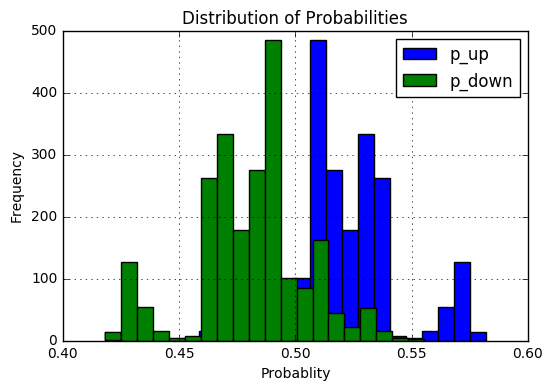

In [14]:
plt.figure()
test_data["p_up"].hist(bins=20)
test_data["p_down"].hist(bins=20)
plt.title("Distribution of Probabilities")
plt.legend(["p_up", "p_down"])
plt.ylabel("Frequency")
plt.xlabel("Probablity")
plt.show()

TRADING STATS
AVG Monthly Return :: -0.12%
STD Monthly        :: 1.68%
SHARPE             :: -0.25
Correlation to SPY :: -0.03
NUMBER OF TRADES   :: 215
SPY MONTHLY RETURN :: 0.76%
SPY STD RETURN     :: 4.44%
SPY SHARPE         :: 0.59


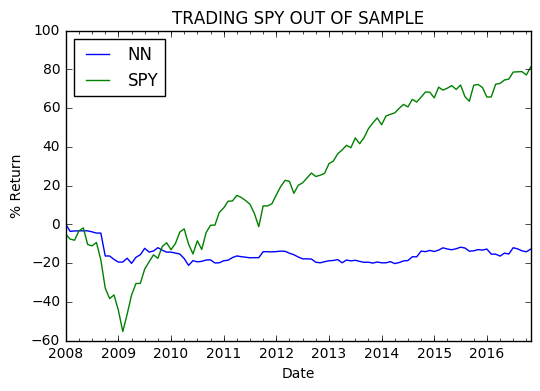

In [15]:
test_data["pnl"] = test_data["Adj Close"].diff().shift(-1).fillna(0)*test_data["positions"]/np.where(test_data["Adj Close"]!=0,test_data["Adj Close"],1)
test_data["perc"] = (test_data["Adj Close"] - test_data["Adj Close"].shift(1)) / test_data["Adj Close"].shift(1)
monthly = test_data.pnl.resample("M").sum()
monthly_spy = test_data["perc"].resample("M").sum()
avg_return = np.mean(monthly)
std_return = np.std(monthly)
sharpe = np.sqrt(12) * avg_return / std_return
print("TRADING STATS")
print("AVG Monthly Return :: " + "{0:.2f}".format(round(avg_return*100,2))+ "%")
print("STD Monthly        :: " + "{0:.2f}".format(round(std_return*100,2))+ "%")
print("SHARPE             :: " + "{0:.2f}".format(round(sharpe,2)))
print("Correlation to SPY :: " + "{0:.2f}".format(round(np.corrcoef(test_data["pnl"], test_data["diff"])[0][1],2)))
print("NUMBER OF TRADES   :: " + str(np.sum(test_data.positions.abs())))
print("SPY MONTHLY RETURN :: " + "{0:.2f}".format(round(monthly_spy.mean()*100,2)) + "%")
print("SPY STD RETURN     :: " + "{0:.2f}".format(round(monthly_spy.std()*100,2)) + "%")
print("SPY SHARPE         :: " + "{0:.2f}".format(round(monthly_spy.mean()/monthly_spy.std()*np.sqrt(12),2)))
(monthly.cumsum()*100).plot()
(monthly_spy.cumsum()*100).plot()
plt.legend(["NN", "SPY"],loc=2)
plt.ylabel("% Return")
plt.title("TRADING SPY OUT OF SAMPLE")
plt.show()

It is interesting to see here how it performs out of sample during the financial crisis. This strategy makes money when most people are not making money! More importantly, this strategy even though it performs worse in the average monthly return, it has a significantly lower volaltility, and therefore a higher Sharpe ratio. Thus, from a quant perespective it is more likely to be profitable (it makes money in many different market timeperiods). More importantly, this strategy is relativly uncorrelated to the market. Try to experiment with this network with different stocks and see what happens to the Sharpe ratio when you have multiple trading streams that are uncorrelated with each other. 

Also notice how the strategy tends to trade less the further in time. Why do you think this is? What could be a reason for this?

Remember when you are trading you can trade with leverage, and increase your return profile (as long as you are willing to handle the down times). The best trading strategies are the ones that can consistantly make money no matter which market they are trading and no matter what is happening in the market. This "edge" is termed alpha in the quant industry.

It is important to notice how much of a drawdown you will experience (http://www.investopedia.com/terms/m/maximum-drawdown-mdd.asp?lgl=no-infinite). Since this is in percentage returns where returns are not reinvested, and we are not holding but trading, the larger the drawdown the harder it is to recover (if you lost 90% of your portfolio then have a 90% gain, you will only be at 19% of your starting value). 

*We can only predict on close prices and not the adjusted close prices. Adjusted close prices incorporate data from the future (stock splits and dividends) which can incorporate bias into our network. However, we must compute our profit/loss using the adjusted close price.

TRADING STATS
AVG Monthly Return :: 0.56%
STD Monthly        :: 5.35%
SHARPE             :: 0.36
Correlation to SPY :: 0.02


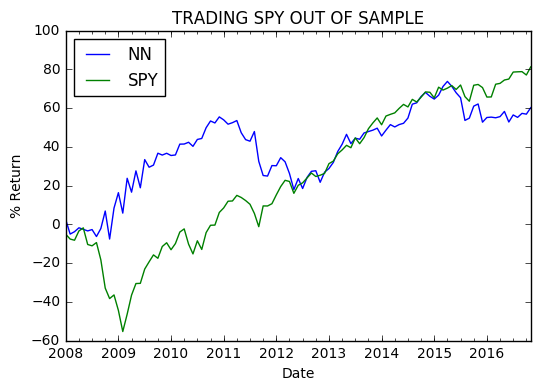

In [16]:
test_data["p_up"] = pd.Series(predicted_label_prob[0][:,0], index = test_data.index)
test_data["p_down"] = predicted_label_prob[0][:,1]
test_data['long_entries'] = np.where((test_data.p_up > 0.50) , 1, 0)
test_data['short_entries'] = np.where((test_data.p_down > 0.50) , -1, 0)
test_data['positions'] = test_data['long_entries'].fillna(0) + test_data['short_entries'].fillna(0)
test_data["pnl"] = test_data["Adj Close"].diff().shift(-1).fillna(0)*test_data["positions"]/np.where(test_data["Adj Close"]!=0,test_data["Adj Close"],1)
monthly = test_data.pnl.resample("M").sum()
avg_return = np.mean(monthly)
std_return = np.std(monthly)
sharpe = np.sqrt(12) * avg_return / std_return
print("TRADING STATS")
print("AVG Monthly Return :: " + "{0:.2f}".format(round(avg_return*100,2))+ "%")
print("STD Monthly        :: " + "{0:.2f}".format(round(std_return*100,2))+ "%")
print("SHARPE             :: " +"{0:.2f}".format(round(sharpe,2)))
print("Correlation to SPY :: " + "{0:.2f}".format(round(np.corrcoef(test_data["pnl"], test_data["diff"])[0][1],2)))
(monthly.cumsum()*100).plot()
(monthly_spy.cumsum()*100).plot()
plt.legend(["NN", "SPY"],loc=2)
plt.ylabel("% Return")
plt.title("TRADING SPY OUT OF SAMPLE")
plt.show()

Notice how if we change it to trying to predict at every instance our performance decreases, most notably the sharpe ratio. The volatility of the trading strategy has increased. Additionally, notice how the drawdowns are more pronounced (how long you are not making money). Here neural networks can be used to learn something even if the goal is not classification for time series data. This is not to say that it cannot be used for well defined timeseries data that can be classified. Try this with a sine wave given the same learning features (minus the volume), and see what happens.

## More Notes
Try changing the batch size, the network itself, the activation functions, and many other features and see how much it affects the output. Notice how it can change dramatically? This means what you have been training on might be noise and you need to refine either the model or more likely the inputs to the network itself. 

Then after you have done that, experiment with seeing how this works with keeping the network fixed and then applied to other timeseries data. Pick a stock in the S&P 500, pick something that is uncorrelated with the S&P 500, try a completely random dataset. How do you expect each of those to do? Should the performance match up with S&P 500 out of sample performance? How about the random data?


In [17]:
# Repeatable factor (used for runtime verification)
print(error)

0.474
